## Supervised Machine Learning - Example 02
# Text Classification

_"A machine learning technique that assigns a set of predefined categories to open-ended text."_

This example uses **Scikit-learn** (http://scikit-learn.org/).

**Scikit-learn** is an open-source machine learning library for Python that offers a variety of regression, classification and clustering algorithms.

## Objective:
* To automatically flag phishing messages using their content.

### Input data:

**Origin:**
* emails-enron.csv: Regular, non-phishy emails from the Enron email corpus;
* emails-phishing.csv: Phishing email corpus.

<i>Both files were created using a custom fork of: https://github.com/diegoocampoh/MachineLearningPhishing</i>

**Features description:**
* ID: (numerical) Extracted e-mail ID from the mbox file;
* Content Type: (object) E-mail's [content type](https://en.wikipedia.org/wiki/MIME);
* Message: (object) E-mail's payload content;

**Label**
* Phishy: (boolean) True if from the phishing e-mail corpus.

## Summary:

1. [Import and Load](#p1)
2. [Data Exploration](#p2)
3. [Prepare the Data Set](#p3)
4. [Train and Test](#p4)
5. [Exercise](#p5)

<a id="p1"></a>
## 1. Import and Load

The data set is a concatenation of two [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) files created from the [Enron email corpus](https://www.cs.cmu.edu/~enron/) and an available [phishing corpus](http://monkey.org/%7Ejose/wiki/doku.php?id=PhishingCorpus).

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
df = pd.concat(map(pd.read_csv, 
                   ['data/emails-enron.csv', 
                    'data/emails-phishing.csv']))
df.head()

,ID,Content Type,Message,Phishy
0,1,text/plain,?\tPay well ? and pay for performance (with bo...,False
1,2,text/plain,Trading Profits\r\n\r\nP. Allen\t\t200\r\nM. G...,False
2,3,text/plain,"John, as requested, please see the attached. I...",False
3,4,text/plain,Trading Profits\r\n\r\nP. Allen 200\r\nM. Gri...,False
4,5,text/plain,? Pay well =01( and pay for performance (with ...,False


<a id="p2"></a>
## 2. Data Exploration

Initial step in data analysis, where we explore a large data set in an unstructured way to uncover initial patterns, characteristics  and points of interest.

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.shape

(4000, 4)

### Check for missing values

Missing data can reduce the statistical power of a study and can produce biased estimates, leading to invalid conclusions ([Why are missing values a problem?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/))

In [5]:
df.isnull().sum()

ID              0
Content Type    0
Message         0
Phishy          0
dtype: int64

### Take a quick look at the *Phishy* label column:

In [6]:
df['Phishy'].unique()

array([False,  True])

In [7]:
df['Phishy'].value_counts()

False    2000
True     2000
Name: Phishy, dtype: int64

We can see that we have a [balanced dataset](https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5): 2000 out of 4000 e-mails (50%) are _Phishy_.

This means that any machine learning model we create has to perform **better than 50%** to beat random chance.

### Check the features' column types

In [8]:
df.dtypes

ID               int64
Content Type    object
Message         object
Phishy            bool
dtype: object

### Bag of Words and TF-IDF

A **Bag of Words** is a simplified representation used in natural language processing, where a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.



**Example:**

In [9]:
# Sentences
s1 = "In a hole in the ground there lived a hobbit."
s2 = "It does not do to leave a live dragon out of your calculations, if you live near him."

In [10]:
# Vocabulary
vocab = {}
i = 1

for word in s1.lower().split()+s2.lower().split():
    if word in vocab:
        continue
    else:
        vocab[word]=i
        i+=1
        
print(vocab)

{'in': 1, 'a': 2, 'hole': 3, 'the': 4, 'ground': 5, 'there': 6, 'lived': 7, 'hobbit.': 8, 'it': 9, 'does': 10, 'not': 11, 'do': 12, 'to': 13, 'leave': 14, 'live': 15, 'dragon': 16, 'out': 17, 'of': 18, 'your': 19, 'calculations,': 20, 'if': 21, 'you': 22, 'near': 23, 'him.': 24}


In [11]:
# Empty vectors with an index for each word in the vocabulary
s1_vector = ['s1']+[0]*len(vocab)

# Map the frequencies of each word to the vectors
for word in s1.lower().split():
    s1_vector[vocab[word]]+=1
    
print(s1_vector)

['s1', 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
# Empty vectors with an index for each word in the vocabulary
s2_vector = ['s2']+[0]*len(vocab)

# Map the frequencies of each word to the vectors
for word in s2.lower().split():
    s2_vector[vocab[word]]+=1
    
print(s2_vector)

['s2', 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
# Vectors comparison
print(f'{s1_vector}\n{s2_vector}')

['s1', 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['s2', 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In the above example, each vector can be considered a **bag of words**. Extending this logic to thousands of entries, we could see that the vocabulary dictionary could grow to hundreds of thousands of words.

In practice, the bag-of-words model is mainly used as a tool of feature generation. After transforming the text into a "bag of words", we can calculate various measures to characterize the text. The most common type of characteristics, or features, calculated from this model is term frequency, namely, the number of times a term appears in the text.

### TF-IDF

**TF-IDF**, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document.

It basically considers term frequencies (word occurrences/number of words in the sentence) and inverse document frequency (total number of sentences/the number of sentences that contain the word), which diminishes the weight of terms that occur very frequently in the set and increases the weight of terms that occur rarely.

### Other interesting NLP definitions

* **Stop words**: frequent words that could be ignored from the vocabulary ('a', 'the', 'and', ...)
* **Tokenization**: dividing documents into individual words (frequently uses morphology concepts)
* **Word stems**: use of the root of a word/token (e.g.: instead of dragon and dragons, use only dragon)
* **Tagging**: adds more dimension to tokens (parts of speech, grammatical dependencies, etc.)

<a id="p3"></a>
## 3. Prepare the Data Set

### Create Feature and Label sets

**Feature** columns are the ones used to predict the **label** columns. This time we want to look at the text.

By **convention**, Features are represented as **X** (uppercase) and Lables as **y** (lowercase).

In [14]:
from sklearn.model_selection import train_test_split

X = df['Message']
y = df['Phishy']

### Split the data into train and test sets

Here we'll assign 70% of the data for training and 30% for testing.

Also, we are setting a `random_state` seed value to ensure results replicability.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train.shape

(2800,)

### CountVectorizer
Text preprocessing, tokenizing and the ability to filter out stopwords are all included in Scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which builds a dictionary of features and transforms documents to feature vectors, similar to a Bag of Words.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train_cv = count_vect.fit_transform(X_train)
X_train_cv.shape

(2800, 82671)

Our training set is now comprised of 2800 e-mails with <font color=green>**82671**</font> features.

In [17]:
# Extracted features
count_vect.get_feature_names_out()

array(['00', '000', '0000', ..., 'ёп2007', 'ёпregions', 'ўз'],
      dtype=object)

### Tfidf Transformer

TF-IDF can then be computed from the count-matrix using Scikit-learn's [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_cv)
X_train_tfidf.shape

(2800, 82671)

The `fit_transform()` method performs two operations in this case: it fits an estimator to the data and then transforms our count-matrix (X_train_cv) to a tf-idf representation.

### TfidfVectorizer
Scikit-learn's [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) combines the CountVectorizer and TfidTransformer steps into one:

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(2800, 82671)

<a id="p4"></a>
## 4. Train and Test


Since our training set needs to be vectorized before being processed by the classifier, we can use a Scikit-learn's [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), a class that behaves like a compound classifier.

In this example, we are going to use a Linear [Support Vector Classification](https://scikit-learn.org/stable/modules/svm.html) algorithm due to its good performance with sparse input ([LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)).

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Pipeline
lsvc = Pipeline([
                  ('tfidf', TfidfVectorizer()),
                  ('clf', LinearSVC()),
                 ])

# Train
lsvc = lsvc.fit(X_train, y_train)  

In [21]:
# Create a prediction set
predictions = lsvc.predict(X_test)

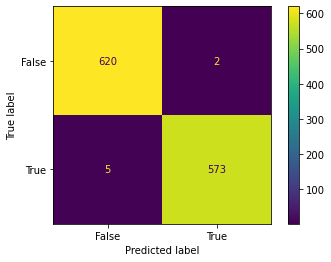

In [22]:
# Print a confusion matrix
cm = metrics.confusion_matrix(y_test, predictions, labels=lsvc.classes_)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lsvc.classes_)
disp.plot()

In [23]:
# Classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99       622
        True       1.00      0.99      0.99       578

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [24]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.9941666666666666


<a id="p5"></a>
## 5. Exercise

### 5.1. Feed new data to the model's `predict()` method:

In [25]:
test_email = "Dear user, \
Your e-mail quota is running out. \
Please follow the link below to fix the issue: \
http://www.mailquota.com?/exec/fix\
and update your account information."

In [26]:
print(lsvc.predict([test_email]))

[ True]


### 5.2. Improve your model by using `stop_words`

In [27]:
stop_words = ...

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Pipeline
lsvc = Pipeline([
                  ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                  ('clf', LinearSVC()),
                 ])

# Train
...

Ellipsis

In [28]:
# Create a prediction set
...

In [29]:
# Print a confusion matrix
...

In [30]:
# Classification report
...

In [31]:
# Print the overall accuracy
...